In [207]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [178]:
import numpy as np
import pandas as pd

In [179]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [180]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [181]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [182]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [326]:
# We can view all of the classes that automap found
Base.classes.keys()
# Display the row's columns and data in dictionary format
Base.metadata.tables['measurement'].columns.keys()
# Display the row's columns and data in dictionary format
Base.metadata.tables['station'].columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [184]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [185]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

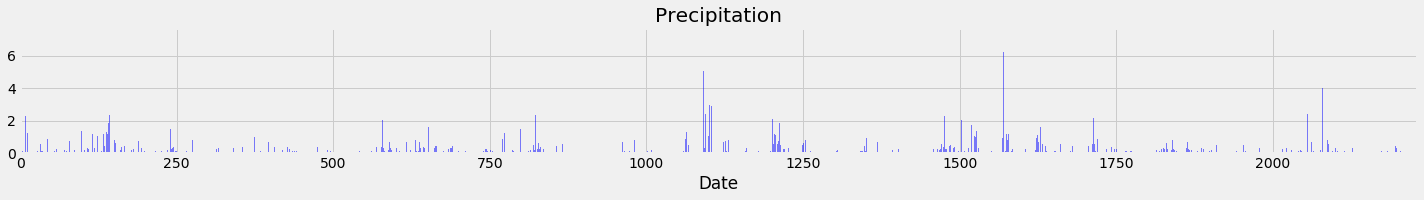

In [194]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


engine.execute('select max(date) from measurement').fetchall()
# Calculate the date 1 year ago from the last data point in the database
engine.execute("select date(max(date) ,'-1 year') from measurement").fetchall()
# Perform a query to retrieve the data and precipitation scores
engine.execute('select * from measurement where date >= "2017-08-01"').fetchall()
# Save the query results as a Pandas DataFrame and set the index to the date column
engine.execute('select * from measurement where date >= "2017-08-01"').fetchall()
# Sort the dataframe by date
rain_df = pd.read_sql_query("select date, prcp from measurement where date >= '2016-08-23';", engine)

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.set_index('date')
rain_df = rain_df.sort_values(by=['date'], ascending=True)
# Set x axis and tick locations
x_axis = np.arange(len(rain_df))
tick_locations = [value for value in x_axis]
rain_df
# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, rain_df["prcp"], color='b', alpha=0.5, align="center")
#plt.xticks(tick_locations, rain_df["date"], rotation="vertical")


# Set x and y limits
plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(rain_df["prcp"]) + 1)

# Set a Title and labels
plt.title("Precipitation")
plt.xlabel("Date")
#plt.ylabel("Average precipitation Inches")
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [187]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df = rain_df.rename(columns={'prcp': 'precipitation'})
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [188]:
# Design a query to show how many stations are available in this dataset?
engine.execute('select count(distinct station) from measurement').fetchall()

[(9,)]

In [327]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('select station, count(station) from measurement  group by station order by 2 desc').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [190]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute('select min(tobs), max(tobs), avg(tobs) from measurement group by station having station = "USC00519281" ').fetchall()

[(54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205B1DA4438>]],
      dtype=object)

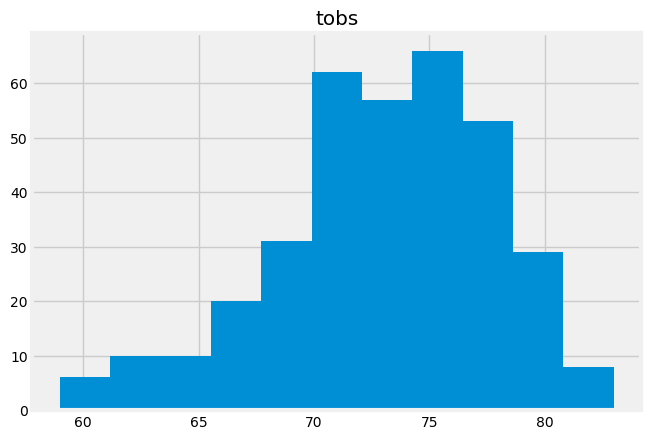

In [224]:
# Choose the station with the highest number of temperature observations.
engine.execute('select station , count(tobs) from measurement group by station  order by  count(tobs) desc').first()
engine.execute('select station , count(tobs) from measurement where station = "USC00519281" and date >= "2016-08-23"').fetchall()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#df_temp = engine.execute('select tobs from measurement where station = "USC00519281" and date >= "2016-08-23"').fetchall()
df_temp = pd.read_sql_query('select tobs from measurement where station = "USC00519281" and date >= "2016-08-23";', engine)

df_temp
# create histogram 
# the histogram of the data

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})


df_temp.hist(bins=11)


![precipitation](Images/station-histogram.png)

In [237]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
     
# function usage example
print(calc_temps('2013-02-28', '2013-04-05'))

[(53.0, 67.86641221374046, 77.0)]


In [317]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#-engine.execute("select date(max(date) ,'-1 year') from measurement").fetchall()
def prev_calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    from datetime import date
    #- Do some manipulation to change the string date to int and subtract year portion 
    #----Manipulate start_date
    syear = int(start_date.split("-")[0]) - 1
    smonth = int(start_date.split("-")[1])
    sdate = int (start_date.split("-")[2])
    #new_sdate_string = syear + "-" + smonth + "-" + sdate
    startDate = date(syear, smonth, sdate)
    #print(startDate)
    
    #----Manipulate end_date
    eyear = int(end_date.split("-")[0]) - 1
    emonth = int(end_date.split("-")[1])
    edate = int (end_date.split("-")[2])
    #new_sdate_string = syear + "-" + smonth + "-" + sdate
    endDate = date(eyear, emonth, edate)
    #print(endDate)
    
    
    #return  session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    #filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all() 
    minT = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all()
    avgT = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all()
    maxT = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all()
    minT = [float(r[0]) for r in minT]
    maxT = [float(r[0]) for r in maxT]
    avgT = [float(r[0]) for r in avgT]
    retT = minT + avgT + maxT
    #rChar="[(,)]"
    #for char in rChar:
    #    minT=minT.replace(char,"")
    return retT
    
    #return [minT , maxT, avgT]
# function usage example
avgTemp = prev_calc_temps('2013-02-28', '2013-03-03')
avgTemp

[65.0, 70.58536585365853, 74.0]

Text(0.5, 1.0, 'Trip Avg Temp')

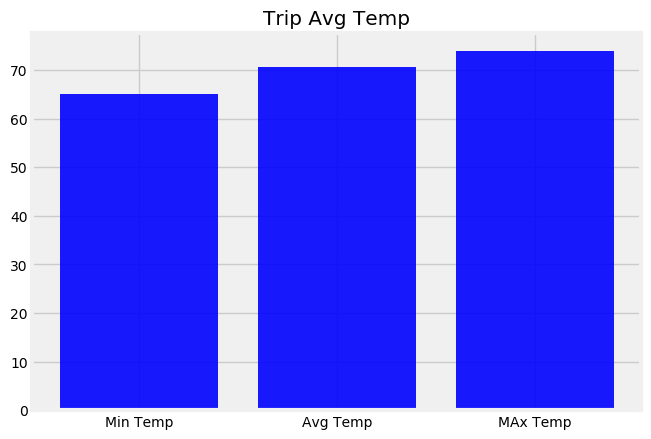

In [318]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = np.arange(len(avgTemp))
plt.bar(x_axis, avgTemp, color='b', alpha=0.9, align="center")
tick_locations = [value for value in x_axis]
tick_locations
plt.xticks(tick_locations, ["Min Temp", "Avg Temp", "MAx Temp"])
# Give our chart some labels and a tile
plt.title("Trip Avg Temp")
#plt.xlabel("Programming Language")
#plt.ylabel("Number of People Using Programming Languages")

In [331]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

engine.execute('select m.station , s.name, s.latitude, s.longitude, s.elevation, sum(m.prcp) "total precipitation"\
from measurement m, station s where  m.date >= "2013-02-28" and m.date < "2013-03-03" \
 and m.station = s.station group by m.station order by sum(m.prcp) desc').fetchall()
#['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.17),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.03),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]

## Optional Challenge Assignment

In [173]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [174]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [175]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [176]:
# Plot the daily normals as an area plot with `stacked=False`
